In [20]:
import os
import sys
import pandas as pd
import numpy as np
import math
from matplotlib import pyplot as plt
import tensorflow as tf
import datetime 
windowSize=5
epochs=200
verbose=True
train=True

## Trial on my stock price data

In [21]:
#based on: https://www.youtube.com/watch?v=c0k-YLQGKjY
#format:
##         X           Y
## [[[1],[2],[3],[4]] [5]

def df_to_windowed_df(dataframe,windowSize=3):
  data=dataframe.to_numpy()
  X=[]
  Y=[]
  
  for i in range(0,len(data)-windowSize):
    # nth=[[a[0],a[1]] for a in data[i:i+windowSize]]
    nth=[[a[1]] for a in data[i:i+windowSize]]
    # print(nth)
    X.append(nth)
    Y.append((data[i+windowSize])[1])
  
  return np.array(X),np.array(Y)
    
## history of tesla share prices
filepath="TSLA.csv"
df=pd.read_csv(filepath)

df.Date = pd.to_datetime(df.Date).astype('int64') / 10**9
X,Y=df_to_windowed_df(df,windowSize=windowSize)

In [22]:
def splitDataset(X,Y,threshold=0.8,valsize=0.01): 
    #threshold means 80% is split train/val
    # valsize means 1% never sees the model in val or training; this is taken from the val side, so val is actually size = 1-threshold-valsize
    threshold_index=round(X.shape[0]*(threshold+valsize))
    valindex=round(X.shape[0]*(1-valsize))
    
    x_train=X[:threshold_index]
    y_train=Y[:threshold_index]
    
    x_val=X[threshold_index:valindex]
    y_val=Y[threshold_index:valindex]
    
    x_test=X[valindex:]
    y_test=Y[valindex:]
    
    return x_train,y_train,x_val,y_val,x_test,y_test

x_train_0,y_train_0,x_val_0,y_val_0,x_test_0,y_test_0=splitDataset(X,Y)

In [23]:
###Normalize the data!

def zscoreNorm_manual(inp,mean,std):
    return (inp-mean)/std

normalize=True
if normalize==True:
    # Order=2 makes it a minmax scaling operation (so that we can de-normalize later)
    # x_train=tf.keras.utils.normalize(x_train_0,axis=0,order=2)
    # y_train=tf.keras.utils.normalize(y_train_0,axis=0,order=2)

    # x_val=tf.keras.utils.normalize(x_val_0,axis=0,order=2)
    # y_val=tf.keras.utils.normalize(y_val_0,axis=0,order=2)

    # x_test=tf.keras.utils.normalize(x_test_0,axis=0,order=np.inf)
    # y_test=tf.keras.utils.normalize(y_test_0,axis=0,order=np.inf)
    
    unNormData={"xtrain":[np.mean(x_train_0,axis=0),np.std(x_train_0,axis=0)],"ytrain":[np.mean(y_train_0,axis=0),np.std(y_train_0,axis=0)],
                "xval":[np.mean(x_val_0,axis=0),np.std(x_val_0,axis=0)],"yval":[np.mean(y_val_0,axis=0),np.std(y_val_0,axis=0)],
                "xtest":[np.mean(x_test_0,axis=0),np.std(x_test_0,axis=0)],"ytest":[np.mean(y_test_0,axis=0),np.std(y_test_0,axis=0)]
                }
    
    
    x_train=zscoreNorm_manual(x_train_0,unNormData["xtrain"][0],unNormData["xtrain"][1])
    y_train=zscoreNorm_manual(y_train_0,unNormData["ytrain"][0],unNormData["ytrain"][1])
    
    x_val=zscoreNorm_manual(x_val_0,unNormData["xval"][0],unNormData["xval"][1])
    y_val=zscoreNorm_manual(y_val_0,unNormData["yval"][0],unNormData["yval"][1])
    
    x_test=zscoreNorm_manual(x_test_0,unNormData["xtest"][0],unNormData["xtest"][1])
    y_test=zscoreNorm_manual(y_test_0,unNormData["ytest"][0],unNormData["ytest"][1])



# OPTED TO DO MANUAL Z-SCALING NORMALIZATION HERE SO THAT I CAN REVERSE IT LATER ON;
# EVEN READING THE DOCS ON THE TF KERAS NORMALIZATION ABOVE IT SEEMED LIKE IT SHOULDVE BEEN WORKING
# BUT I COUDLNT REVERSE IT; SOMETHING WEIRD WAS GOING ON.

In [24]:
# THIS IS JUST TO VALIDATE THAT THE NORMALIZATION AND DENORMALIZATION PROCESS WORKS
if verbose:
    print(y_test_0[-4])
    print("mean",unNormData['ytest'][0],np.mean(y_test_0,axis=0))
    print("std",unNormData['ytest'][1],np.std(y_test_0,axis=0))
    print(y_test[-4])
    print(y_test[-4]*unNormData['ytest'][1]+unNormData['ytest'][0])

242.740005
mean 229.48294005882352 229.48294005882352
std 12.962013469213561 12.962013469213561
1.02276278084911
242.740005


In [25]:
if verbose:
    print(tf.config.list_physical_devices())

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [26]:
model=tf.keras.models.Sequential()

model.add(tf.keras.layers.InputLayer((x_train.shape[1],x_train.shape[2])))
model.add(tf.keras.layers.LSTM(256,return_sequences=True))
model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.LSTM(128,return_sequences=True))
model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.LSTM(64,return_sequences=True))
model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.LSTM(32))
model.add(tf.keras.layers.Dropout(0.15))
model.add(tf.keras.layers.Dense(16,'relu'))
model.add(tf.keras.layers.Dense(1,'linear'))

model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 5, 256)            264192    
                                                                 
 dropout_3 (Dropout)         (None, 5, 256)            0         
                                                                 
 lstm_4 (LSTM)               (None, 5, 128)            197120    
                                                                 
 dropout_4 (Dropout)         (None, 5, 128)            0         
                                                                 
 lstm_5 (LSTM)               (None, 5, 64)             49408     
                                                                 
 dropout_5 (Dropout)         (None, 5, 64)             0         
                                                                 
 lstm_6 (LSTM)               (None, 32)               

In [27]:
logspath=os.path.join('logs','model_init')
csv_logger = tf.keras.callbacks.CSVLogger(os.path.join(logspath,'training.log'), separator=',', append=False)
cp=tf.keras.callbacks.ModelCheckpoint(logspath,save_best_only=True)
model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam())

In [28]:
if train:
    #putting this here so we can blindly run the whole script and still get the plots without HAVING to train
    # each time. Bc we still access the 'model' via a load model command below.
    history=model.fit(x_train,y_train,epochs=epochs,validation_data=(x_val,y_val),callbacks=[cp,csv_logger],verbose=verbose)

Epoch 1/200
84/86 [============================>.] - ETA: 0s - loss: 0.2288

INFO:tensorflow:Assets written to: logs\model_init\assets


INFO:tensorflow:Assets written to: logs\model_init\assets


86/86 [==============================] - 22s 195ms/step - loss: 0.2249 - val_loss: 0.2101
Epoch 2/200
86/86 [==============================] - ETA: 0s - loss: 0.0291

INFO:tensorflow:Assets written to: logs\model_init\assets


INFO:tensorflow:Assets written to: logs\model_init\assets


86/86 [==============================] - 15s 181ms/step - loss: 0.0291 - val_loss: 0.1447
Epoch 3/200
85/86 [============================>.] - ETA: 0s - loss: 0.0195

INFO:tensorflow:Assets written to: logs\model_init\assets


INFO:tensorflow:Assets written to: logs\model_init\assets


86/86 [==============================] - 15s 173ms/step - loss: 0.0203 - val_loss: 0.1399
Epoch 4/200
86/86 [==============================] - ETA: 0s - loss: 0.0228

INFO:tensorflow:Assets written to: logs\model_init\assets


INFO:tensorflow:Assets written to: logs\model_init\assets


86/86 [==============================] - 15s 172ms/step - loss: 0.0228 - val_loss: 0.1184
Epoch 5/200
83/86 [===========================>..] - ETA: 0s - loss: 0.0211

INFO:tensorflow:Assets written to: logs\model_init\assets


INFO:tensorflow:Assets written to: logs\model_init\assets


86/86 [==============================] - 15s 173ms/step - loss: 0.0215 - val_loss: 0.1108
Epoch 6/200
86/86 [==============================] - 2s 17ms/step - loss: 0.0212 - val_loss: 0.1251
Epoch 7/200
85/86 [============================>.] - ETA: 0s - loss: 0.0153

INFO:tensorflow:Assets written to: logs\model_init\assets


INFO:tensorflow:Assets written to: logs\model_init\assets


86/86 [==============================] - 18s 209ms/step - loss: 0.0152 - val_loss: 0.1097
Epoch 8/200
86/86 [==============================] - ETA: 0s - loss: 0.0144

INFO:tensorflow:Assets written to: logs\model_init\assets


INFO:tensorflow:Assets written to: logs\model_init\assets


86/86 [==============================] - 15s 176ms/step - loss: 0.0144 - val_loss: 0.1051
Epoch 9/200
83/86 [===========================>..] - ETA: 0s - loss: 0.0194

INFO:tensorflow:Assets written to: logs\model_init\assets


INFO:tensorflow:Assets written to: logs\model_init\assets


86/86 [==============================] - 17s 197ms/step - loss: 0.0213 - val_loss: 0.0954
Epoch 10/200
86/86 [==============================] - 2s 18ms/step - loss: 0.0217 - val_loss: 0.1069
Epoch 11/200
86/86 [==============================] - 1s 15ms/step - loss: 0.0182 - val_loss: 0.1023
Epoch 12/200
86/86 [==============================] - 1s 15ms/step - loss: 0.0161 - val_loss: 0.1067
Epoch 13/200
86/86 [==============================] - 1s 15ms/step - loss: 0.0158 - val_loss: 0.1075
Epoch 14/200
86/86 [==============================] - 1s 15ms/step - loss: 0.0170 - val_loss: 0.0977
Epoch 15/200
83/86 [===========================>..] - ETA: 0s - loss: 0.0150

INFO:tensorflow:Assets written to: logs\model_init\assets


INFO:tensorflow:Assets written to: logs\model_init\assets


86/86 [==============================] - 15s 172ms/step - loss: 0.0150 - val_loss: 0.0947
Epoch 16/200
86/86 [==============================] - 1s 17ms/step - loss: 0.0176 - val_loss: 0.1105
Epoch 17/200
84/86 [============================>.] - ETA: 0s - loss: 0.0137

INFO:tensorflow:Assets written to: logs\model_init\assets


INFO:tensorflow:Assets written to: logs\model_init\assets


86/86 [==============================] - 17s 204ms/step - loss: 0.0139 - val_loss: 0.0892
Epoch 18/200
86/86 [==============================] - 2s 20ms/step - loss: 0.0152 - val_loss: 0.1000
Epoch 19/200
84/86 [============================>.] - ETA: 0s - loss: 0.0139

INFO:tensorflow:Assets written to: logs\model_init\assets


INFO:tensorflow:Assets written to: logs\model_init\assets


86/86 [==============================] - 18s 214ms/step - loss: 0.0137 - val_loss: 0.0863
Epoch 20/200
86/86 [==============================] - 2s 20ms/step - loss: 0.0145 - val_loss: 0.0953
Epoch 21/200
86/86 [==============================] - 2s 18ms/step - loss: 0.0155 - val_loss: 0.0899
Epoch 22/200
85/86 [============================>.] - ETA: 0s - loss: 0.0111

INFO:tensorflow:Assets written to: logs\model_init\assets


INFO:tensorflow:Assets written to: logs\model_init\assets


86/86 [==============================] - 14s 170ms/step - loss: 0.0110 - val_loss: 0.0806
Epoch 23/200
86/86 [==============================] - 1s 17ms/step - loss: 0.0151 - val_loss: 0.1107
Epoch 24/200
86/86 [==============================] - 1s 15ms/step - loss: 0.0118 - val_loss: 0.0907
Epoch 25/200
86/86 [==============================] - 1s 16ms/step - loss: 0.0159 - val_loss: 0.0830
Epoch 26/200
86/86 [==============================] - 1s 15ms/step - loss: 0.0127 - val_loss: 0.0853
Epoch 27/200
86/86 [==============================] - 1s 14ms/step - loss: 0.0130 - val_loss: 0.0880
Epoch 28/200
86/86 [==============================] - 1s 15ms/step - loss: 0.0115 - val_loss: 0.0892
Epoch 29/200
86/86 [==============================] - 1s 15ms/step - loss: 0.0154 - val_loss: 0.1000
Epoch 30/200
86/86 [==============================] - 1s 15ms/step - loss: 0.0135 - val_loss: 0.0850
Epoch 31/200
84/86 [============================>.] - ETA: 0s - loss: 0.0128

INFO:tensorflow:Assets written to: logs\model_init\assets


INFO:tensorflow:Assets written to: logs\model_init\assets


86/86 [==============================] - 15s 173ms/step - loss: 0.0127 - val_loss: 0.0698
Epoch 32/200
86/86 [==============================] - 1s 17ms/step - loss: 0.0125 - val_loss: 0.0781
Epoch 33/200
86/86 [==============================] - 1s 15ms/step - loss: 0.0193 - val_loss: 0.1092
Epoch 34/200
86/86 [==============================] - 1s 16ms/step - loss: 0.0141 - val_loss: 0.0704
Epoch 35/200
86/86 [==============================] - 1s 15ms/step - loss: 0.0111 - val_loss: 0.0861
Epoch 36/200
83/86 [===========================>..] - ETA: 0s - loss: 0.0128

INFO:tensorflow:Assets written to: logs\model_init\assets


INFO:tensorflow:Assets written to: logs\model_init\assets


86/86 [==============================] - 16s 187ms/step - loss: 0.0130 - val_loss: 0.0664
Epoch 37/200
86/86 [==============================] - 2s 18ms/step - loss: 0.0102 - val_loss: 0.0666
Epoch 38/200
86/86 [==============================] - 1s 17ms/step - loss: 0.0097 - val_loss: 0.0709
Epoch 39/200
84/86 [============================>.] - ETA: 0s - loss: 0.0117

INFO:tensorflow:Assets written to: logs\model_init\assets


INFO:tensorflow:Assets written to: logs\model_init\assets


86/86 [==============================] - 16s 188ms/step - loss: 0.0117 - val_loss: 0.0651
Epoch 40/200
86/86 [==============================] - 2s 18ms/step - loss: 0.0112 - val_loss: 0.0720
Epoch 41/200
86/86 [==============================] - 1s 15ms/step - loss: 0.0106 - val_loss: 0.0839
Epoch 42/200
86/86 [==============================] - 1s 16ms/step - loss: 0.0141 - val_loss: 0.0895
Epoch 43/200
86/86 [==============================] - 1s 16ms/step - loss: 0.0106 - val_loss: 0.0677
Epoch 44/200
86/86 [==============================] - 1s 16ms/step - loss: 0.0115 - val_loss: 0.0746
Epoch 45/200
86/86 [==============================] - 1s 16ms/step - loss: 0.0104 - val_loss: 0.0690
Epoch 46/200
86/86 [==============================] - 1s 16ms/step - loss: 0.0091 - val_loss: 0.0757
Epoch 47/200
86/86 [==============================] - 1s 16ms/step - loss: 0.0134 - val_loss: 0.0755
Epoch 48/200
86/86 [==============================] - 1s 16ms/step - loss: 0.0107 - val_loss: 0.0810
E

INFO:tensorflow:Assets written to: logs\model_init\assets


INFO:tensorflow:Assets written to: logs\model_init\assets


86/86 [==============================] - 16s 185ms/step - loss: 0.0092 - val_loss: 0.0594
Epoch 58/200
86/86 [==============================] - 2s 18ms/step - loss: 0.0092 - val_loss: 0.0643
Epoch 59/200
83/86 [===========================>..] - ETA: 0s - loss: 0.0117

INFO:tensorflow:Assets written to: logs\model_init\assets


INFO:tensorflow:Assets written to: logs\model_init\assets


86/86 [==============================] - 17s 202ms/step - loss: 0.0120 - val_loss: 0.0580
Epoch 60/200
86/86 [==============================] - 2s 19ms/step - loss: 0.0095 - val_loss: 0.0678
Epoch 61/200
86/86 [==============================] - 2s 18ms/step - loss: 0.0123 - val_loss: 0.0668
Epoch 62/200
86/86 [==============================] - 2s 20ms/step - loss: 0.0111 - val_loss: 0.0693
Epoch 63/200
86/86 [==============================] - ETA: 0s - loss: 0.0096

INFO:tensorflow:Assets written to: logs\model_init\assets


INFO:tensorflow:Assets written to: logs\model_init\assets


86/86 [==============================] - 17s 194ms/step - loss: 0.0096 - val_loss: 0.0575
Epoch 64/200
86/86 [==============================] - ETA: 0s - loss: 0.0085

INFO:tensorflow:Assets written to: logs\model_init\assets


INFO:tensorflow:Assets written to: logs\model_init\assets


86/86 [==============================] - 15s 179ms/step - loss: 0.0085 - val_loss: 0.0520
Epoch 65/200
86/86 [==============================] - ETA: 0s - loss: 0.0091

INFO:tensorflow:Assets written to: logs\model_init\assets


INFO:tensorflow:Assets written to: logs\model_init\assets


86/86 [==============================] - 15s 176ms/step - loss: 0.0091 - val_loss: 0.0520
Epoch 66/200
85/86 [============================>.] - ETA: 0s - loss: 0.0093

INFO:tensorflow:Assets written to: logs\model_init\assets


INFO:tensorflow:Assets written to: logs\model_init\assets


86/86 [==============================] - 16s 191ms/step - loss: 0.0092 - val_loss: 0.0512
Epoch 67/200
86/86 [==============================] - 2s 19ms/step - loss: 0.0095 - val_loss: 0.0585
Epoch 68/200
85/86 [============================>.] - ETA: 0s - loss: 0.0091

INFO:tensorflow:Assets written to: logs\model_init\assets


INFO:tensorflow:Assets written to: logs\model_init\assets


86/86 [==============================] - 16s 189ms/step - loss: 0.0091 - val_loss: 0.0505
Epoch 69/200
86/86 [==============================] - 2s 18ms/step - loss: 0.0100 - val_loss: 0.0565
Epoch 70/200
86/86 [==============================] - ETA: 0s - loss: 0.0089

INFO:tensorflow:Assets written to: logs\model_init\assets


INFO:tensorflow:Assets written to: logs\model_init\assets


86/86 [==============================] - 15s 178ms/step - loss: 0.0089 - val_loss: 0.0462
Epoch 71/200
86/86 [==============================] - 1s 16ms/step - loss: 0.0107 - val_loss: 0.0532
Epoch 72/200
86/86 [==============================] - 1s 15ms/step - loss: 0.0084 - val_loss: 0.0503
Epoch 73/200
86/86 [==============================] - 1s 15ms/step - loss: 0.0106 - val_loss: 0.0591
Epoch 74/200
86/86 [==============================] - 1s 15ms/step - loss: 0.0090 - val_loss: 0.0490
Epoch 75/200
86/86 [==============================] - 1s 14ms/step - loss: 0.0086 - val_loss: 0.0510
Epoch 76/200
86/86 [==============================] - 1s 15ms/step - loss: 0.0076 - val_loss: 0.0540
Epoch 77/200
86/86 [==============================] - 1s 15ms/step - loss: 0.0076 - val_loss: 0.0479
Epoch 78/200
86/86 [==============================] - 1s 15ms/step - loss: 0.0082 - val_loss: 0.0498
Epoch 79/200
86/86 [==============================] - 1s 15ms/step - loss: 0.0094 - val_loss: 0.0645
E

In [29]:
# this is just making sure we can access it
model=tf.keras.models.load_model(logspath)
log_data = pd.read_csv(os.path.join(logspath,'training.log'), sep=',', engine='python') #this loads up the history

In [30]:
train_predictions=model.predict(x_train).flatten()
yflat=y_train.flatten()

86/86 [==============================] - 2s 6ms/step


In [31]:
train_predictions=model.predict(x_train).flatten()
train_results=pd.DataFrame(data={'Train Predictions':train_predictions,'Actuals':yflat})

if verbose:
    train_results

86/86 [==============================] - 0s 5ms/step


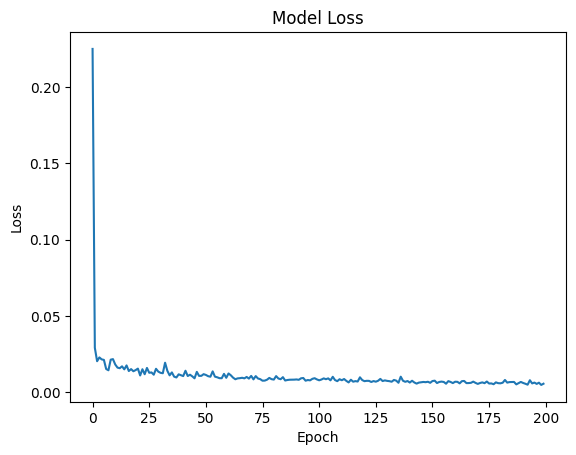

In [32]:
## Check for overfitting
from matplotlib import pyplot as plt
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [33]:
## evaluate the model
testscore=model.evaluate(x_test,y_test)
if verbose: 
    print(testscore)

2/2 [==============================] - 1s 10ms/step - loss: 0.3127
0.31265395879745483


In [34]:
# Add dates here because we arent training with the date becasue that is kind of annoying to do.
def genDateSplit(dates,windowSize,threshold=0.8,valsize=0.01): 
    #threshold means 80% is split train/val
    # valsize means 1% never sees the model in val or training; this is taken from the val side, so val is actually size = 1-threshold-valsize
    threshold_index=round(X.shape[0]*(threshold+valsize))+windowSize
    valindex=round(X.shape[0]*(1-valsize))+windowSize
    
    a=dates[windowSize:threshold_index]
    b=dates[threshold_index:valindex]
    c=dates[valindex:]
    
    print(len(a),len(b),len(c))
    
    return a,b,c

unixdates=df.Date.tolist()
ndates=[]
for i in unixdates:
    ndates.append(datetime.datetime.utcfromtimestamp(i).strftime('%Y-%m-%d'))
# print(ndates)

trainDates,val_dates,testDates=genDateSplit(ndates,windowSize)


2742 609 34


In [35]:
if verbose:
    # compare lengths of the data things
    print("train", len(trainDates),y_train.shape[0])
    print("val", len(val_dates),y_val.shape[0])
    print("test", len(testDates),y_test.shape[0])

train 2742 2742
val 609 609
test 34 34


In [36]:
new_x_set4Predict=np.concatenate((x_test[-1:,-9:,:],np.array([[y_test[-1]]]).reshape(1, 1, 1)),axis=1)

val_predictions=model.predict(x_val)
test_predictions=model.predict(x_test)
future_predict=model.predict(new_x_set4Predict)

1/1 [==============================] - 1s 1s/step


In [37]:
## un-normalize data so that we can have the context to it
def unNormalize(normddata,meann,stddev):
    # print(meann,stddev)
    orig=normddata*stddev + meann
    return orig

normed_ytrain=unNormalize(y_train,unNormData['ytrain'][0],unNormData['ytrain'][1])
normed_yval=unNormalize(y_val,unNormData['yval'][0],unNormData['yval'][1])
normed_ytest=unNormalize(y_test,unNormData['ytest'][0],unNormData['ytest'][1])

normValPreedict=unNormalize(val_predictions,unNormData['yval'][0],unNormData['yval'][1])
normTestPredictions=unNormalize(test_predictions,unNormData['ytest'][0],unNormData['ytest'][1])
normed_futurePrediction=unNormalize(future_predict,unNormData['ytest'][0],unNormData['ytest'][1])


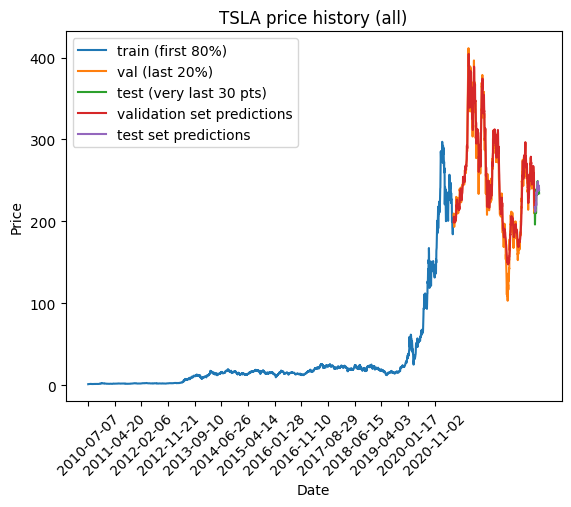

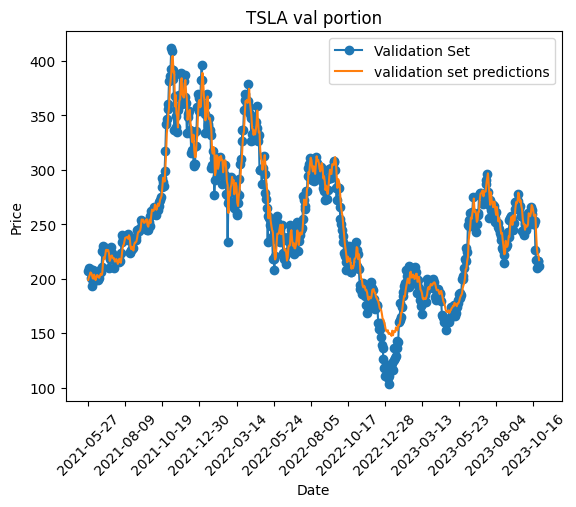

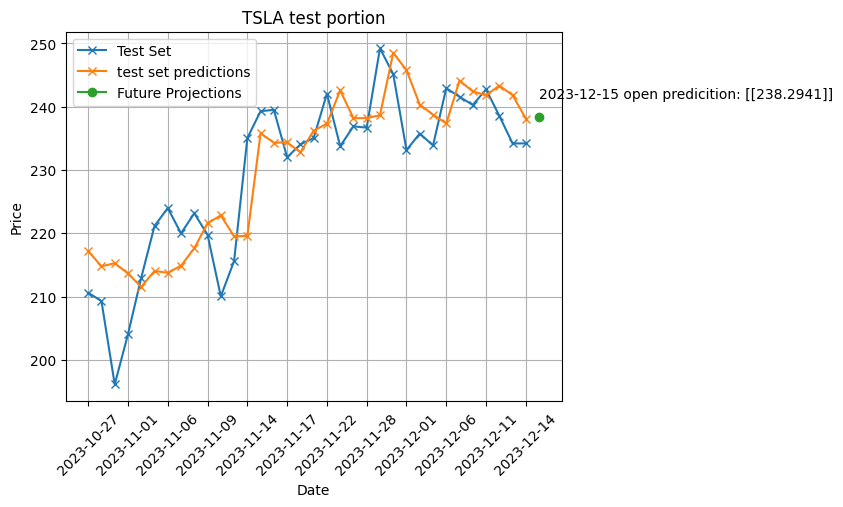

IT LOOKS LIKE THERE IS A ONE STEP OFFSET HERE, WHEN YOU ZOOM IN, BUT THERE ISNT, THE MODEL JUST SUCKS


In [38]:
#Plot the real stock prices
plt.plot(trainDates,normed_ytrain.flatten(),label="train (first 80%)")
plt.xticks(trainDates[::200],rotation=45)
plt.plot(val_dates,normed_yval.flatten(),label="val (last 20%)")
plt.plot(testDates,normed_ytest.flatten(),label="test (very last 30 pts)")

plt.plot(val_dates,normValPreedict,label="validation set predictions")
plt.plot(testDates,normTestPredictions,label="test set predictions")
plt.title('TSLA price history (all)')
plt.ylabel('Price')
plt.xlabel('Date')
plt.legend() 
plt.show()

plt.plot(val_dates,normed_yval,label="Validation Set",marker='o')

plt.plot(val_dates,normValPreedict,label="validation set predictions")
plt.xticks(val_dates[::50],rotation=45)
plt.title('TSLA val portion')
plt.ylabel('Price')
plt.xlabel('Date')
plt.legend() 
plt.show()

plt.plot(testDates,normed_ytest,label="Test Set",marker='x')
plt.plot(testDates,normTestPredictions,label="test set predictions",marker='x')
futureDate=(datetime.datetime.strptime(testDates[-1],'%Y-%m-%d')+datetime.timedelta(days=1)).strftime('%Y-%m-%d')
plt.plot(futureDate,normed_futurePrediction,label="Future Projections",marker='o')
plt.annotate(f"{futureDate} open predicition: {normed_futurePrediction}",[futureDate,normed_futurePrediction+3])
plt.xticks(testDates[::3],rotation=45)
plt.title('TSLA test portion')
plt.ylabel('Price')
plt.xlabel('Date')
plt.grid()
plt.legend() 
plt.show()

print('IT LOOKS LIKE THERE IS A ONE STEP OFFSET HERE, WHEN YOU ZOOM IN, BUT THERE ISNT, THE MODEL JUST SUCKS')
